#  GLEAM Matching in Python 3.7

### Importing packages and configuring Matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from astropy import units as u
import glob
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import *
from astropy.coordinates import match_coordinates_sky
from itertools import cycle
import scipy.integrate as integrate
from scipy.interpolate import griddata
from itertools import permutations
from itertools import combinations
from collections import Counter
from itertools import product
from math import e
from matplotlib import transforms
import matplotlib.colors as colors

import scipy
from scipy import io
from scipy.stats import iqr, norm
from scipy.stats.kde import gaussian_kde

/Users/aadmin/anaconda3/envs/astroconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aadmin/anaconda3/envs/astroconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from astropy.io import fits

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')

## Opening the data

* The following three functions have been taken from the following github repository and converted to Python 3. If we want to work further with this code, we need to work on better citing this.



In [4]:
def separator_catalog(data, source_label='catalog'):
    '''
    THIS CODE IS FROM THE CLUSTERER CODE- WORK ON CITING THIS
    
    The separator splits all data which has been read in by the collector
    into individual lists for point sources and extended sources.
    
    This is primarily written to be used by the Seeker.
    
    Args:
        data: The variable assigned to the IDL .sav file which has been
            read in by the collector.

    Returns:
        data: A dictonary containing two keys:
            1. "extsources": The same data structure containing only extended sources.
            2. "psources": The same data structure containing only point sources.
    '''

    # A source is determined to be a point source if
    # it does not contain any extended components.
    point_data = [[data['data'][i][source_label][j]
                   for j in range(len(data['data'][i][source_label]))
                  if data['data'][i][source_label][j]['EXTEND'] is None]
                  for i in range(len(data['data']))]

    # A source is determined to be an extended source if
    # it does contain any extended components.
    extended_data = [[data['data'][i][source_label][j]
                      for j in range(len(data['data'][i][source_label]))
                      if data['data'][i][source_label][j]['EXTEND']
                      is not None]
                     for i in range(len(data['data']))]
    return {'extsources': extended_data, 'psources': point_data}

In [5]:
def seeker_catalog(data, source_label='catalog'):
    """
    THIS CODE IS FROM THE CLUSTERER CODE- WORK ON CITING THIS
    
    The seeker splits all data which has been read in by the collector
    into individual lists for RA, DEC, FLUX, XX, and YY values.
    Separate lists are made for point sources, extended sources,
    and all sources.
    
    Args:
        data: The variable assigned to the IDL .sav file which has been
            read in by the collector.

    Returns:
        Separated lists for ID, X, Y, RA, DEC, STON, FREQ, ALPHA, GAIN, FLAG,
        XX, YY, XY, YX, I, Q, U, and V values for point sources, extended sources,
        and all sources.
    """

    # Separating data into point sources and extended sources.
    separated = separator_catalog(data, source_label=source_label)

    # Creating individual lists for RA, DEC, FLUX, XX, and YY values
    # for point sources.
    point_sources_ID = [[separated['psources'][i][j]['ID']
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_X = [[separated['psources'][i][j]['X']
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_Y = [[separated['psources'][i][j]['Y']
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_RA = [[separated['psources'][i][j]['RA']
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_DEC = [[separated['psources'][i][j]['DEC']
                          for j in range(len(separated['psources'][i]))]
                         for i in range(len(separated['psources']))]
    point_sources_STON = [[separated['psources'][i][j]['STON']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_FREQ = [[separated['psources'][i][j]['FREQ']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_ALPHA = [[separated['psources'][i][j]['ALPHA']
                            for j in range(len(separated['psources'][i]))]
                           for i in range(len(separated['psources']))]
    point_sources_GAIN = [[separated['psources'][i][j]['GAIN']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_FLAG = [[separated['psources'][i][j]['FLAG']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_XY = [[separated['psources'][i][j]['FLUX']['XY'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_YX = [[separated['psources'][i][j]['FLUX']['YX'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_I = [[separated['psources'][i][j]['FLUX']['I'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_Q = [[separated['psources'][i][j]['FLUX']['Q'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_U = [[separated['psources'][i][j]['FLUX']['U'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_V = [[separated['psources'][i][j]['FLUX']['V'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_BEAM = [np.asarray(np.asarray(point_sources_XX[i]) +
                            np.asarray(point_sources_YY[i])) / np.asarray(point_sources_I[i])
                            for i in range(len(separated['psources']))]

    

    # Creating individual lists for RA, DEC, FLUX, XX, and YY values
    # for extended sources.
    EO_sources_ID = [[[separated['extsources'][i][j]['EXTEND']['ID'][k]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['ID']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_X = [[[separated['extsources'][i][j]['EXTEND']['X'][k]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['X']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_Y = [[[separated['extsources'][i][j]['EXTEND']['Y'][k]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['Y']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k]
                        for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))]
                       for j in range(len(separated['extsources'][i]))]
                      for i in range(len(separated['extsources']))]
    EO_sources_STON = [[[separated['extsources'][i][j]['EXTEND']['STON'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['STON']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_FREQ = [[[separated['extsources'][i][j]['EXTEND']['FREQ'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['FREQ']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_ALPHA = [[[separated['extsources'][i][j]['EXTEND']['ALPHA'][k]
                          for k in range(len(separated['extsources'][i][j]['EXTEND']['ALPHA']))]
                         for j in range(len(separated['extsources'][i]))]
                        for i in range(len(separated['extsources']))]
    EO_sources_GAIN = [[[separated['extsources'][i][j]['EXTEND']['GAIN'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['GAIN']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_FLAG = [[[separated['extsources'][i][j]['EXTEND']['FLAG'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['FLAG']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_XY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XY'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_YX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YX'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_Q = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['Q'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_U = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['U'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_V = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['V'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_BEAM = [[np.asarray(np.asarray(EO_sources_XX[i][j]) +
                        np.asarray(EO_sources_YY[i][j])) / np.asarray(EO_sources_I[i][j])
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]

    # Fixing RA values to range between -180 and +180.
    for i in range(len(data['data'])):
        for j in range(len(EO_sources_RA[i])):
            for k in range(len(EO_sources_RA[i][j])):
                if EO_sources_RA[i][j][k] > 180:
                    EO_sources_RA[i][j][k] -= 360
        for j in range(len(point_sources_RA[i])):
            if point_sources_RA[i][j] > 180:
                point_sources_RA[i][j] -= 360

    # Adding point source and extended source lists to create
    # lists for RA, DEC, FLUX, XX, and YY values for all sources.
    all_RA = [[point_sources_RA[i][j]
               for j in range(len(point_sources_RA[i]))] +
              [EO_sources_RA[i][j][k]
              for j in range(len(EO_sources_RA[i]))
              for k in range(len(EO_sources_RA[i][j]))]
              for i in range(len(data['data']))]
    all_DEC = [[point_sources_DEC[i][j]
                for j in range(len(point_sources_DEC[i]))] +
               [EO_sources_DEC[i][j][k]
               for j in range(len(EO_sources_DEC[i]))
               for k in range(len(EO_sources_DEC[i][j]))]
               for i in range(len(data['data']))]
    all_I = [[point_sources_I[i][j]
              for j in range(len(point_sources_I[i]))] +
             [EO_sources_I[i][j][k]
             for j in range(len(EO_sources_I[i]))
             for k in range(len(EO_sources_I[i][j]))]
             for i in range(len(data['data']))]
    all_XX = [[point_sources_XX[i][j]
               for j in range(len(point_sources_XX[i]))] +
              [EO_sources_XX[i][j][k]
              for j in range(len(EO_sources_XX[i]))
              for k in range(len(EO_sources_XX[i][j]))]
              for i in range(len(data['data']))]
    all_YY = [[point_sources_YY[i][j]
               for j in range(len(point_sources_YY[i]))] +
              [EO_sources_YY[i][j][k]
              for j in range(len(EO_sources_YY[i]))
              for k in range(len(EO_sources_YY[i][j]))]
              for i in range(len(data['data']))]
    all_BEAM = [np.asarray(np.asarray(all_XX[i]) +
                np.asarray(all_YY[i])) / np.asarray(all_I[i])
                for i in range(len(data['data']))]

    return {'point_sources_ID': point_sources_ID,
            'point_sources_X': point_sources_X,
            'point_sources_Y': point_sources_Y,
            'point_sources_RA': point_sources_RA,
            'point_sources_DEC': point_sources_DEC,
            'point_sources_STON': point_sources_STON,
            'point_sources_FREQ': point_sources_FREQ,
            'point_sources_ALPHA': point_sources_ALPHA,
            'point_sources_GAIN': point_sources_GAIN,
            'point_sources_FLAG': point_sources_FLAG,
            'point_sources_XX': point_sources_XX,
            'point_sources_YY': point_sources_YY,
            'point_sources_XY': point_sources_XY,
            'point_sources_YX': point_sources_YX,
            'point_sources_I': point_sources_I,
            'point_sources_Q': point_sources_Q,
            'point_sources_U': point_sources_U,
            'point_sources_V': point_sources_V,
            'point_sources_BEAM':point_sources_BEAM,
            'EO_sources_BEAM': EO_sources_BEAM,
            'EO_sources_ID': EO_sources_ID,
            'EO_sources_X': EO_sources_X,
            'EO_sources_Y': EO_sources_Y,
            'EO_sources_RA': EO_sources_RA,
            'EO_sources_DEC': EO_sources_DEC,
            'EO_sources_STON': EO_sources_STON,
            'EO_sources_FREQ': EO_sources_FREQ,
            'EO_sources_ALPHA': EO_sources_ALPHA,
            'EO_sources_GAIN': EO_sources_GAIN,
            'EO_sources_FLAG': EO_sources_FLAG,
            'EO_sources_XX': EO_sources_XX,
            'EO_sources_YY': EO_sources_YY,
            'EO_sources_XY': EO_sources_XY,
            'EO_sources_YX': EO_sources_YX,
            'EO_sources_I': EO_sources_I,
            'EO_sources_Q': EO_sources_Q,
            'EO_sources_U': EO_sources_U,
            'EO_sources_V': EO_sources_V,
            'all_RA': all_RA, 'all_DEC': all_DEC, 'all_I': all_I,
            'all_XX': all_XX, 'all_YY': all_YY, 'all_BEAM': all_BEAM}

In [6]:
def collector(path):
    '''
    The collector reads one or multiple IDL .sav files
    and appends each .sav file's entire data structure to a list.
    
    Args:
        path: The file system location of an IDL .sav file
            or a folder of IDL .sav files.

    Returns:
        data: A dictonary containing two keys:
            1. "data": The data structure of the IDL .sav file(s).
            2. "filenames": The filename associated with the IDL .sav file(s).
        
    '''

    # Glob module finds all the pathnames matching a specified pattern
    # according to the rules used by the Unix shell.
    filenames = glob.glob(path)

    # Filenames are read into python with the scipy.io.readsav function.
    # Data structures and filenames and appended to their own lists
    # with dictionary keys.
    data = {'data': [scipy.io.readsav(filenames[i], python_dict=True)
            for i in range(len(filenames))], 'filenames': filenames}

    # An example for accessing the data structure from the
    # first or only .sav file read in by collector:
    # data[0]['data']
    #
    # An example for accessing the filename from the
    # fourth .sav file read in by collector:
    # data[3]['filenames']

    return data


## Defining the directory containing the Source Array data and importing the GLEAM catalog
* Should also work on citing the GLEAM catalog.

In [18]:
directory = '/Users/student/kelcey/new source arrays/'
paths = glob.glob(directory + '*.sav')

In [13]:
GLEAM_path = '/Users/student/kelcey/GLEAM_v2_plus_rlb2019.sav'
GLEAM_data = collector(GLEAM_path)
GLEAM_seek = seeker_catalog(GLEAM_data)

## The Matching Algorithm

**WARNING**: This cell will take an hour or two to run for 20 Observations

What follows is a line-by-line breakdown of the below algorithm. It should take a series of .sav files and return a Data Frame of each of the observations matched to the GLEAM catalog.

* Function Call: When the function is called, it requires two arguments, directory and GLEAM_seek. Directory is an absolute path on your computer that contains a set of .sav files. GLEAM_seek is the GLEAM catalog after it has been run through the seeker_catalog function defiened above. This is identical to clstr.seeker but with a few keywords changed to acomodate the way the GLEAM file is stored. 

* Line 11: Paths is defined here as a series of absoulte paths to all the .sav files in the directory provided when the function is called. Glob Documentation: https://docs.python.org/2/library/glob.html

* Lines 14-16: These lines open the GLEAM_seek object provided on function call and extract the RA, DEC, and I Band Flux.

* Lines 19-20: The Pandas DataFrame that will be returned at the end of the function is created. It now has 3 columns, each containing the information imported in lines 14-16. N = 0 is also defined here to be used later in future column names.

* Line 25: This is the begining of the major for loop. It will loop through every path in the paths variable created in line 11. The paths variable is cutoff here to only include the first 15 .sav files in the directory. This can be adjusted based on computer strength and time available to run the code. As is, this code will take about half an hour to loop over these first 15 files.

* Lines 28-29: The N variable defined outside of the for loop is increased by one to track the observation number. The collector functiton is called to organize the data.

* Lines 33-75: This is where each file is opened and the information about their components are collected. d_s is where the information about every object in the observation is stored. Each of these individual objects is looped through and checked for an extended component. If there is no extetnded component for an object, it is considered a point source. If there is an extended component, then the object can be considered a point source or it can be considered as a series of points. These points have their own RAs, DECs, and Fluxes. A few arrays are built in this step. The point source RA, DEC, and I-Mag(Magnitude of Unpolarized Light) arrays will always be assigned a value regardless of the extended components. If there is point source information, but not extended component information, the information for the point source is added to the information arrays. This allows for simpler data processing later on. 

* Lines 82-85: This is the section of the function that matches the observation to GLEAM. It utilizes astropy's match_to_catalog_sky function. The documentation for this function can be found here: https://docs.astropy.org/en/stable/coordinates/matchsep.html (Matching Catalogs Section, First Block). First, the RAs and DECs from both GLEAM and the observation are converted into a list of SkyCoordinates, with units defined as Degrees. The match_to_catalog_sky function will return 3 arrays when given these two arrays of coordinates, the idx, d2d, and d3d arrays. The d3d array deals with 3-Dimensional distances and, since we feed the function no information about these, it returns an empty d3d array. We still call it beacuse it is part of the syntax of match_to_catalog_sky. The idx array is an array of indices that indicate positions of stars in the observation in GLEAM. For example, if an idx array that looked something like idx = [50, 1, 15] was returned, that would mean that the 50th object in our observation was the closest match for the 0th object in GLEAM, the 1st object in the observation mathced the 1st object in GLEAM, and the 15th object in our observation matched the 2nd object in GLEAM. This array is an important tool because it allows us to index any information about the observation with the idx array to return a new array of the data, but re-ordered to be the same length and in the same order as GLEAM. The other array returned by the match_to_catalog_sky function is the d2d array. This array contains the matching distance between objects in GLEAM and objects in our observation. It is already in the same order and shape as the idx array. This array is very important because it allows us to throw out mismatched pairs. The function starts with an object in GLEAM and looks for the closest object in the observation. That match could be a few hundred arc seconds away, or a few tens of degrees. This d2d array will be used to constriain our matches.

* Lines 88-96: This is the section where the matches are constrained and poor matches are thrown out. While the d2d array is an important tool, the change in magnitude must also be considered. The resolution of the MWA array that recorded this data is around 100 arc seconds. This low resolution means that matching based only on distance between matchces would be a poor choice. Here, we limit the matching distance to 0.1 Degreees (360 Arc seconds) to cast a bit of a wide net for matchces. This is then further constrainend to only include objects within  +/- $3 \over 4$ the GLEAM magnitude. This ensures that a source of 0.05 Jy won't macth with brighter 20-30 Jy sources in the same area. Anything that does not match these criteria is replaced with a 0 for the magnitude of that observation. This allows us to easily throw out data when working with this DataFrames, but also allows us to keep other information about the source in case we want to look at the match anyway.

* Lines 99-113: Here is where all the information is collected and stored in the DataFrame created in line 20. The idx array is utulized to order the data so that it has the same order and shape as GLEAM. New columns are created in the DataFrame for each of these new sets of data, utilizing the N variable that was changed at the begining of the for loop. The Data Frame is returned.

In [27]:
def match_to_gleam(directory, GLEAM_data):
    """
    Matches all the .sav files in a given directory with GLEAM
    
    directory is an absolute path to the data
    
    GLEAM_seek is the GLEAM catalog after being run through the corrected seeker function
    
    """
    #Create paths to all the .sav files in the specified directory
    paths = glob.glob(directory + '*source_array.sav')
    ra_gleam = []
    dec_gleam = []
    imag_gleam = []
    
    ra_gleam_ext = []
    dec_gleam_ext = []
    imag_gleam_ext = []
    #Load the GLEAM data
    size = GLEAM_data['data'][0]['catalog'].shape[0]
    for i in range(size):
        if GLEAM_data['data'][0]['catalog'][i]['EXTEND'] is None:
            ra_gleam.append(GLEAM_data['data'][0]['catalog'][i]['RA'])
            dec_gleam.append(GLEAM_data['data'][0]['catalog'][i]['DEC'])
            imag_gleam.append(GLEAM_data['data'][0]['catalog'][i]['FLUX']['I'])
            ra_gleam_ext.append(0)
            dec_gleam_ext.append(0)
            imag_gleam_ext.append(0)
        else:
            ra_gleam.append(GLEAM_data['data'][0]['catalog'][i]['RA'])
            dec_gleam.append(GLEAM_data['data'][0]['catalog'][i]['DEC'])
            imag_gleam.append(GLEAM_data['data'][0]['catalog'][i]['FLUX']['I'])
            glm_mag_eo = []
            for j in range(0, GLEAM_data['data'][0]['catalog'][i]['FLUX'].shape[0]):
                glm_mag_eo.append(GLEAM_data['data'][0]['catalog'][i]['EXTEND']['FLUX'][j]['I'])
            imag_gleam_ext.append(glm_mag_eo)
            ra_gleam_ext.append(GLEAM_data['data'][0]['catalog'][i]['EXTEND']['RA'])
            dec_gleam_ext.append(GLEAM_data['data'][0]['catalog'][i]['EXTEND']['DEC'])
                
            
            
    
    #Create a Pandas Data Frame with the RA, DEC, and GLEAM Magnitudes
    n=0
    df = pd.DataFrame({'RA': ra_gleam,'Mag GLEAM': imag_gleam,  'DEC' : dec_gleam, 'RA EO GLEAM':ra_gleam_ext, 
                      'DEC EO GLEAM': dec_gleam_ext, 'Mag EO GLEAM': imag_gleam_ext})
    
    #Look at each path in the directory
    #WARNING: 2 files takes 15-20 minutes to load. DO NOT change the indecies unless 
    #you are prepared to wait a while. There are over 300k stars in GLEAM
    for path in paths:
        
        #Collect the data for each path
        n = n + 1
        data = collector(path)
        #x = seeker_catalog(data, source_label = 'source_array')
        
        eo = []
        eo_ra = []
        eo_dec = []
        ps_RA = []
        ps_DEC = []
        i_mag = []
        EO_imag = []
        
        ps_ston = []
        eo_ston = []

        try:
            d_s = data['data'][0]['catalog']
        except:
            d_s = data['data'][0]['source_array']
     
        for d in d_s:
            if d['EXTEND'] is None:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EO_imag.append(d['FLUX']['I'])
                eo_ra.append(d['RA'])
                eo_dec.append(d['DEC'])
                i_mag.append(d['FLUX']['I'])
                ps_ston.append(d['STON'])
                eo_ston.append(d['STON'])
                
            else:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EOmags = []
                eoston = []
                for i in range(0, d['EXTEND']['FLUX'].shape[0]):
                    EOmags.append(d['EXTEND']['FLUX'][i]['I'])
                    eoston.append(d['EXTEND']['STON'][i])
                eo_ston.append(np.array(eoston))
                EO_imag.append(np.array(EOmags))
                eo_ra.append(d['EXTEND']['RA'])
                eo_dec.append(d['EXTEND']['DEC'])
                i_mag.append(d['FLUX']['I'])
                ps_ston.append(d['STON'])

                
        #Match this path with the GLEAM catalog
        #idx: an array of indices corresponding to matches
        #d2d: the two dimensional distances between these matches
        #d3d: three dimensional distances between matches. This array is blank becasue we do 
        #not have 3 dimensional data, but the match_to_catalog_sky function requires it anyway
        catalog = SkyCoord(ra=ps_RA*u.deg, dec=ps_DEC*u.deg)  
        c = SkyCoord(ra=ra_gleam*u.deg, dec=dec_gleam*u.deg)  
        idx, d2d, d3d = c.match_to_catalog_sky(catalog)  
               
        #Possible source of error because the below statement is worded a little strange
        #Only return matches within one degree 
        mags = []
        imags = np.array(i_mag)[idx]
        nums = np.arange(0, len(idx))
        for num in nums:
            if (d2d[num] < (0.1*u.deg)) and ((imags[num] > imag_gleam[num] + (3/4)*imag_gleam[num]) or (imags[num] > (3/4)*imag_gleam[num])):
                mags.append(imags[num])
            else: 
                mags.append(0)

        #Add a new column to the data frame with the information from these observations     
        s_mag = pd.Series(mags)
        s_dist = pd.Series(d2d)
        df['Mag {}'.format(n)] = s_mag
        df['Distance {}'.format(n)] = s_dist
        
        df['RA {}'.format(n)] = np.array(ps_RA)[idx]
        df['DEC {}'.format(n)] = np.array(ps_DEC)[idx]
        df['EO RA {}'.format(n)] = np.array(pd.Series(eo_ra))[idx]
        df['EO DEC {}'.format(n)] = np.array(pd.Series(eo_dec))[idx]
        df['EO Mag {}'.format(n)] = np.array(pd.Series(EO_imag))[idx]
        df['STON {}'.format(n)] = np.array(ps_ston)[idx]
        df['EO STON {}'.format(n)] = np.array(pd.Series(eo_ston))[idx]
        
    return df

def match_to_gleam(directory, GLEAM_seek):
    """
    Matches all the .sav files in a given directory with GLEAM
    
    directory is an absolute path to the data
    
    GLEAM_seek is the GLEAM catalog after being run through the corrected seeker function
    
    """
    #Create paths to all the .sav files in the specified directory
    paths = glob.glob(directory + '*.sav')
    
    #Load the GLEAM data
    ra_gleam = np.array(GLEAM_seek['point_sources_RA'][0])
    dec_gleam = np.array(GLEAM_seek['point_sources_DEC'][0])
    imag_gleam = np.array(GLEAM_seek['point_sources_I'][0])
    
    #Create a Pandas Data Frame with the RA, DEC, and GLEAM Magnitudes
    n=0
    df = pd.DataFrame({'RA': ra_gleam,'Mag GLEAM': imag_gleam,  'DEC' : dec_gleam})
    
    #Look at each path in the directory
    #WARNING: 2 files takes 15-20 minutes to load. DO NOT change the indecies unless 
    #you are prepared to wait a while. There are over 300k stars in GLEAM
    for path in paths:
        
        #Collect the data for each path
        n = n + 1
        data = collector(path)

        #Defining empty lists to be used later
        #Should clean this up with list comprehension when I have the time.
        eo = []
        eo_ra = []
        eo_dec = []
        ps_RA = []
        ps_DEC = []
        i_mag = []
        EO_imag = []
        ps_ston = []
        eo_ston = []

        #Open the data for this file
        d_s = data['data'][0]['source_array']
         
        #Loop through each object in the observation
        # If EXTEND is none, it is a point source and we will save the relavent data.
        # If EXTEND is not none, there are extended components to this observation. This means that 
        # FHD has returned a component array for the observation. We need to loop through
        # this array and save data for each component within it.
        for d in d_s:
            if d['EXTEND'] is None:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EO_imag.append(d['FLUX']['I'])
                eo_ra.append(d['RA'])
                eo_dec.append(d['DEC'])
                i_mag.append(d['FLUX']['I'])
                ps_ston.append(d['STON'])
                eo_ston.append(d['STON'])
                
            else:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EOmags = []
                eoston = []
                for i in range(0, d['EXTEND']['FLUX'].shape[0]):
                    EOmags.append(d['EXTEND']['FLUX'][i]['I'])
                    eoston.append(d['EXTEND']['STON'][i])
                eo_ston.append(np.array(eoston))
                EO_imag.append(np.array(EOmags))
                eo_ra.append(d['EXTEND']['RA'])
                eo_dec.append(d['EXTEND']['DEC'])
                i_mag.append(d['FLUX']['I'])
                ps_ston.append(d['STON'])

                
        #Match this path with the GLEAM catalog
        #idx: an array of indices corresponding to matches
        #d2d: the two dimensional distances between these matches
        #d3d: three dimensional distances between matches. This array is blank becasue we do 
        #not have 3 dimensional data, but the match_to_catalog_sky function requires it anyway
        catalog = SkyCoord(ra=ps_RA*u.deg, dec=ps_DEC*u.deg)  
        c = SkyCoord(ra=ra_gleam*u.deg, dec=dec_gleam*u.deg)  
        idx, d2d, d3d = c.match_to_catalog_sky(catalog)  
               
        #Possible source of error because the below statement is worded a little strange
        #Only return matches within one degree 
        mags = []
        imags = np.array(i_mag)[idx]
        nums = np.arange(0, len(idx))
        for num in nums:
            if (d2d[num] < (0.1*u.deg)) and ((imags[num] > imag_gleam[num] + (3/4)*imag_gleam[num]) or (imags[num] > (3/4)*imag_gleam[num])):
                mags.append(imags[num])
            else: 
                mags.append(0)

        #Add a new column to the data frame with the information from this path      
        s_mag = pd.Series(mags)
        s_dist = pd.Series(d2d)
        df['Mag {}'.format(n)] = s_mag
        df['Distance {}'.format(n)] = s_dist
        
        #The relavent data is assigned to new columns and indexed with the idx array. This puts the data
        #in the same order as the GLEAM catalog so the Data Frame can be read as a different source for
        #each individual row in the table.
        df['RA {}'.format(n)] = np.array(ps_RA)[idx]
        df['DEC {}'.format(n)] = np.array(ps_DEC)[idx]
        df['EO RA {}'.format(n)] = np.array(eo_ra)[idx]
        df['EO DEC {}'.format(n)] = np.array(eo_dec)[idx]
        df['EO Mag {}'.format(n)] = np.array(EO_imag)[idx]
        df['STON {}'.format(n)] = np.array(ps_ston)[idx]
        df['EO STON {}'.format(n)] = np.array(eo_ston)[idx]
        
    return df

In [28]:
table = match_to_gleam(directory, GLEAM_data)
table

,DEC,DEC EO GLEAM,Mag EO GLEAM,Mag GLEAM,RA,RA EO GLEAM,Mag 1,Distance 1,RA 1,DEC 1,...,EO STON 81,Mag 82,Distance 82,RA 82,DEC 82,EO RA 82,EO DEC 82,EO Mag 82,STON 82,EO STON 82
0,-89.687309,0,0,[0.30337256],357.914368,0,0,29.591951,32.472790,-60.151016,...,"[0.0, 0.0]",0,47.732639,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
1,-89.213310,0,0,[0.22761767],338.336243,0,0,29.394375,32.472790,-60.151016,...,"[0.0, 0.0]",0,47.987778,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
2,-89.155968,0,0,[0.45125127],348.399048,0,0,29.247942,32.472790,-60.151016,...,"[0.0, 0.0]",0,47.862293,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
3,-88.750610,0,0,[1.5286423],345.296844,0,0,29.012854,32.472790,-60.151016,...,"[0.0, 0.0]",0,47.991127,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
4,-88.740990,0,0,[0.2907949],318.784729,0,0,29.517834,32.472790,-60.151016,...,"[0.0, 0.0]",0,48.515247,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
5,-88.825325,0,0,[0.31576866],349.592712,0,0,28.998211,32.472790,-60.151016,...,"[0.0, 0.0]",0,47.888744,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
6,-88.430840,0,0,[0.25329855],351.902374,0,0,28.673538,32.472790,-60.151016,...,"[0.0, 0.0]",0,47.880516,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
7,-88.290367,0,0,[0.1132844],335.838379,0,0,28.940722,32.472790,-60.151016,...,"[0.0, 0.0]",0,48.358570,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
8,-88.139534,0,0,[0.41670793],344.928528,0,0,28.623037,32.472790,-60.151016,...,"[0.0, 0.0]",0,48.133862,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"
9,-88.058319,0,0,[0.42663422],359.296143,0,0,28.241980,32.472790,-60.151016,...,"[0.0, 0.0]",0,47.669273,86.307549,-42.259365,"[86.32325, 86.2115, 86.29515]","[-42.251804, -42.260292, -42.31081]","[[0.2973614], [0.043049622], [0.04288032]]",2.188386,"[0.0, 0.0, 0.0]"


In [193]:
np.sum(table.loc[307462][6::9])

array([3572.4775], dtype=float32)

## Displaying GLEAM
* Here, we can get an idea of the size and shape of GLEAM. Each source is assigned a random color and the size of the source is proportional to it's brightness. The large star is Caseopia A, at 17,693 Jy, it is out of frame for GLEAM but must be taken into consideration for it's extreme brightness in radio. The next brightest source in GLEAM is a few hundred Jy.

In [12]:
col = ['gray', 'silver', 'rosybrown', 'firebrick', 'red', 'darksalmon', 'sienna', 'sandybrown', 'tan', 
       'gold', 'darkkhaki', 'olivedrab', 'chartreuse', 'darkgreen', 'seagreen', 'mediumspringgreen',
       'lightseagreen', 'darkcyan', 'darkturquoise', 'deepskyblue', 'slategray', 'royalblue', 'navy', 
       'blue', 'mediumpurple', 'darkorchid', 'm', 'mediumvioletred', 'palevioletred', 'lightcoral', 
       'maroon', 'coral', 'peachpuff', 'darkorange', 'orange', 'darkgoldenrod', 'olive', 'yellowgreen',
       'lawngreen', 'lightgreen', 'g', 'mediumseagreen', 'darkslategrey', 'cadetblue', 'skyblue', 
       'dodgerblue']

/home/kelcey/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


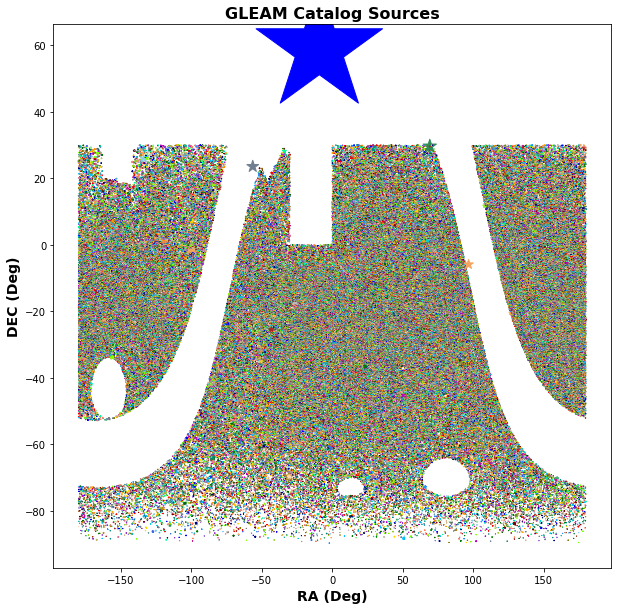

In [13]:
cols = np.random.choice(col, len(np.array(GLEAM_seek['point_sources_RA'][0])))
plt.scatter(table['RA'], table['DEC'], s = table['Mag GLEAM'], marker = '*', color = cols)
plt.title('GLEAM Catalog Sources')
plt.xlabel('RA (Deg)')
plt.ylabel('DEC (Deg)');

In [96]:
table.loc[75219][12::9]

EO Mag 1     [[0.8176223], [0.7402997], [0.6700105], [0.606...
EO Mag 2     [[0.7695594], [0.70148313], [0.63928133], [0.5...
EO Mag 3     [[0.79372305], [0.71891445], [0.65648675], [0....
EO Mag 4     [[0.72541076], [0.65866464], [0.59737676], [0....
EO Mag 5     [[0.8020932], [0.73077726], [0.6657443], [0.60...
EO Mag 6     [[0.71039873], [0.64704376], [0.5853796], [0.5...
EO Mag 7                                           [1.0782112]
EO Mag 8                                           [1.1190069]
EO Mag 9                          [[0.62218237], [0.47999752]]
EO Mag 10                        [[0.15330999], [0.024809381]]
EO Mag 11                                          [0.7479336]
EO Mag 12                                          [0.7650616]
EO Mag 13    [[0.09889669], [0.09385021], [0.092259645], [0...
EO Mag 14                                           [5.839805]
EO Mag 15                                          [0.7671303]
EO Mag 16                                          [1.1

## Exploring some of the brighter observed sourcecs

In [97]:
def plot_source(index):
    """
    Plots a source over many observations given it's index in GLEAM
    """

    mags = table.loc[index][6::9]
    mags_eo = table.loc[index][12::9]
    ras = np.array(table.loc[index][10::9])
    decs = np.array(table.loc[index][11::9])
    mag_change = []
    for i in range(0, len(mags)):
        try:
            if mags[i] !=0:
                mag_change.append(mags[i])
                plt.scatter(ras[i], decs[i], s = mags_eo[i], 
                        label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
        except:
            if np.sum(mags[i]) !=0:
                mag_change.append(mags[i])
                plt.scatter(ras[i], decs[i], s = mags_eo[i], 
                        label = 'Observation {}, {} Jy'.format(i+1, mags[i]))
            
                plt.legend();
    plt.scatter(table.loc[index]['RA'], table.loc[index]['DEC'], color = 'k', marker = '*', label = 'GLEAM')
    plt.xlabel('RA (Degrees)')
    plt.ylabel('DEC (Degrees)')
    plt.title('Source {}, Marker Size Proportional to Component Magnitude'.format(index))
    plt.legend();

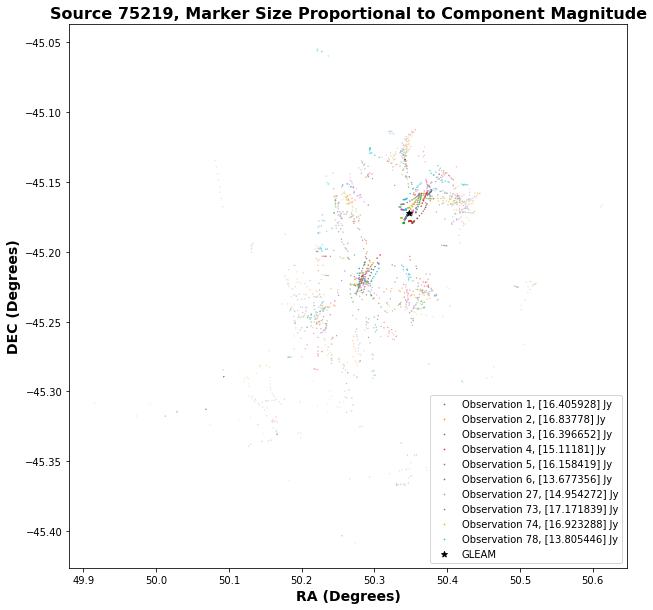

In [198]:
plot_source(75219)
plt.savefig('/Users/student/kelcey/Images/Source75219scatter')

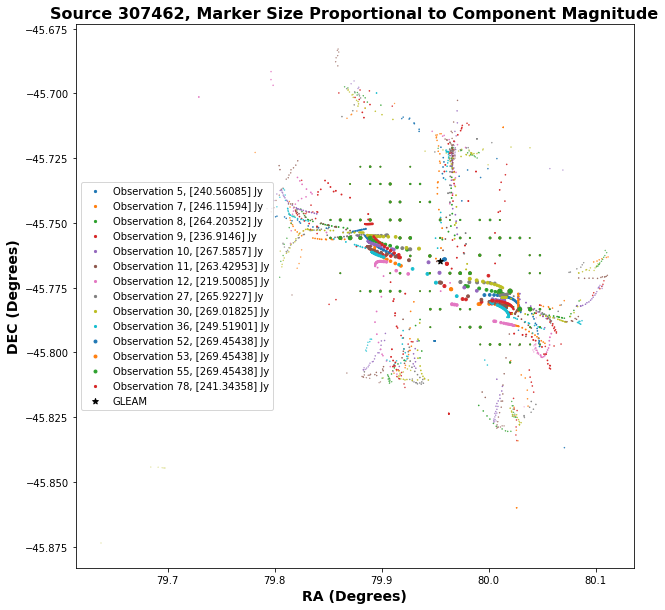

In [197]:
plot_source(307462)
plt.savefig('/Users/student/kelcey/Images/Source307462scatter')

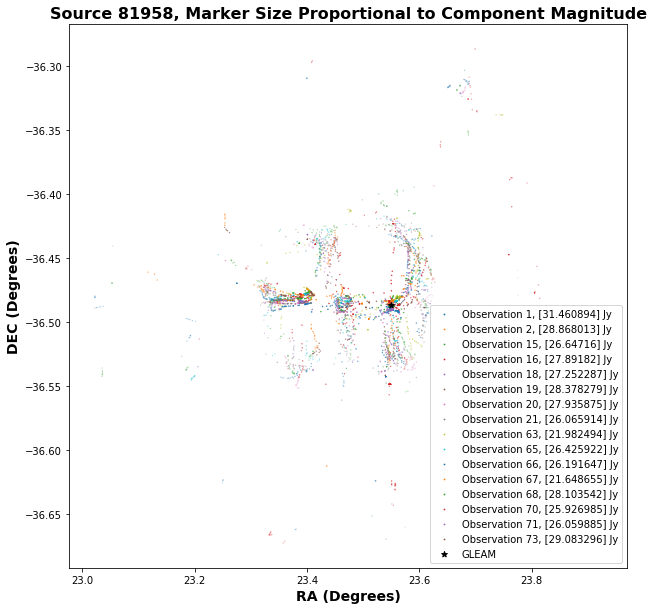

In [100]:
plot_source(81958)

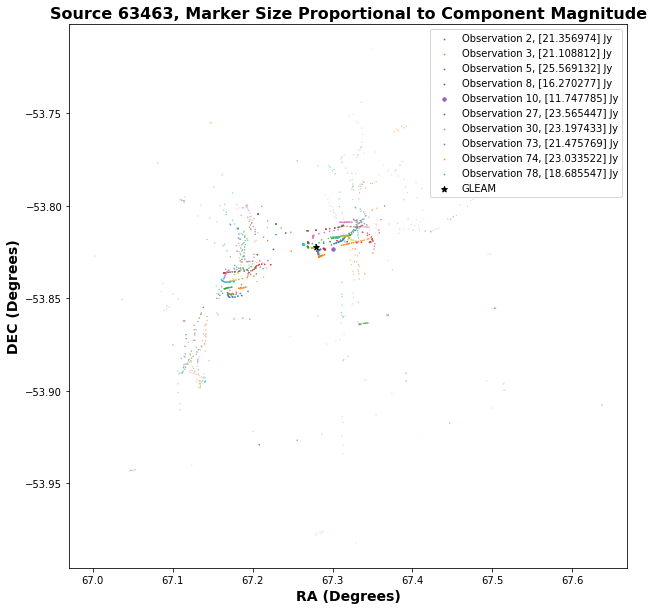

In [199]:
plot_source(63463)
plt.savefig('/Users/student/kelcey/Images/Source63463scatter')

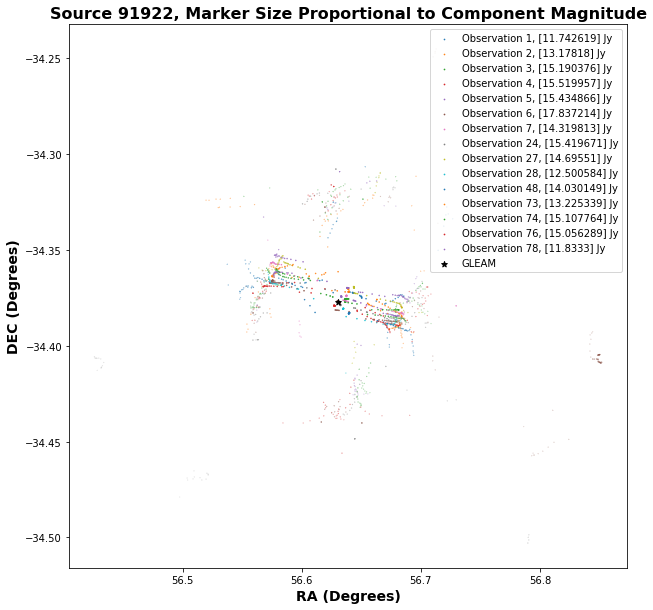

In [102]:
plot_source(91922)

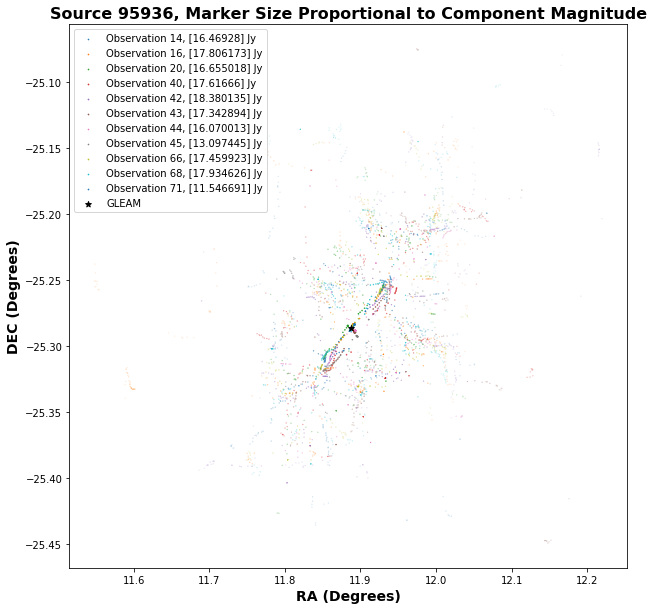

In [103]:
plot_source(95936)

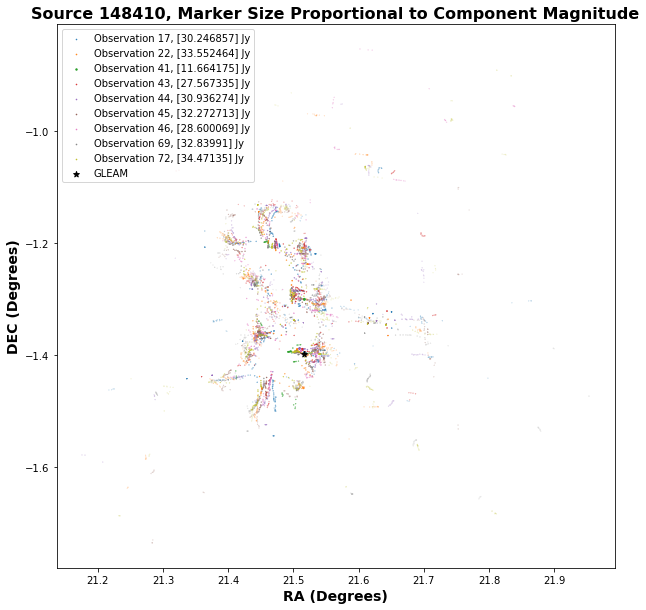

In [104]:
plot_source(148410)

## Organizing the data into pixelated images
* Note: many of these images are flipped when compared to previous images. This is due to the nature of the matrix algebra. We will correct the axes to reflect the propper RA/DEC

In [15]:
def pixel_image(table, index):
    """
    table is a Pandas DataFrame generated by the match_to_GELAM function
    
    index is the index of the object to be imaged
    """
    mags = table.loc[index][6::9]
    mags_eo = table.loc[index][12::9]
    ras = np.array(table.loc[index][10::9])
    decs = np.array(table.loc[index][11::9])
    mag_change = []
    image_ra = []
    image_dec = []
    image_mag = []
    for n in range(0, len(mags)):
        if mags[n] !=0:
            image_ra.append(ras[n])
            image_dec.append(decs[n])
            image_mag.append(mags_eo[n])
                
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    for i in range(0, len(image_ra)):
        xmins.append(np.min(image_ra[i]))
        xmaxs.append(np.max(image_ra[i]))
        ymins.append(np.min(image_dec[i]))
        ymaxs.append(np.max(image_dec[i]))
    xmin = np.min(xmins)
    xmax = np.max(xmaxs)
    ymin = np.min(ymins)
    ymax = np.max(ymaxs)
    
    data = np.matrix(np.zeros((100,100)))
    
    x_axis = np.linspace(xmin - 0.001, xmax + 0.001, num=100, endpoint=True)
    y_axis = np.linspace(ymin - 0.001, ymax + 0.001, num=100, endpoint=True)

    for m in range(0, len(image_ra)):
        ra = image_ra[m]
        dec = image_dec[m]
        mag = image_mag[m]
        for i in range(0, len(ra)):
            pos_mag = mag[i]
            for j in range (0, len(x_axis)):
                if x_axis[j] < ra[i] and x_axis[j+1] > ra[i]:
                    x_pos = j
            for k in range(0, len(y_axis)):
                if y_axis[k] < dec[i] and y_axis[k+1] > dec[i]:
                    y_pos = k
            data[x_pos, y_pos] =  data[x_pos, y_pos] + pos_mag[0]
       
    return plt.imshow(data, origin = 'lower', cmap = 'gist_ncar')         

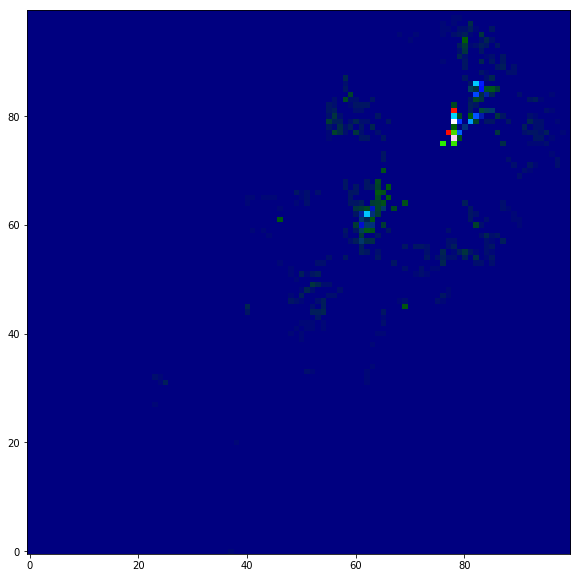

In [27]:
pixel_image(table, 75219);

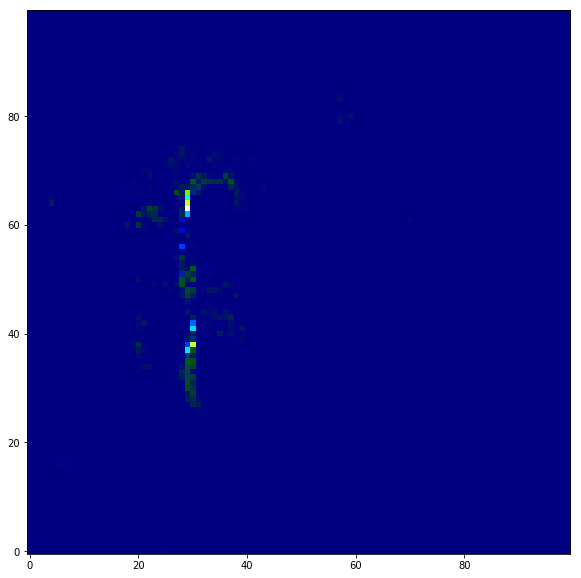

In [28]:
pixel_image(table, 81958);

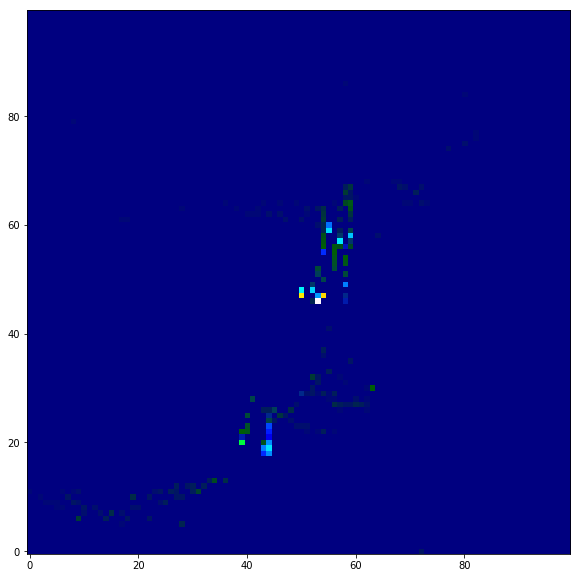

In [29]:
pixel_image(table, 63463);

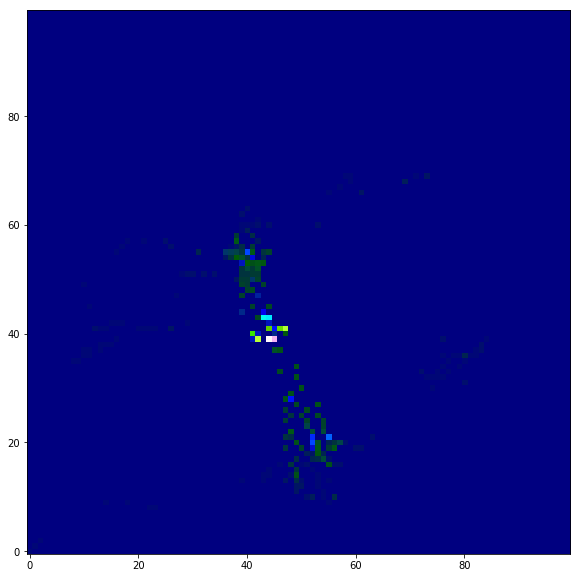

In [30]:
pixel_image(table, 91922);

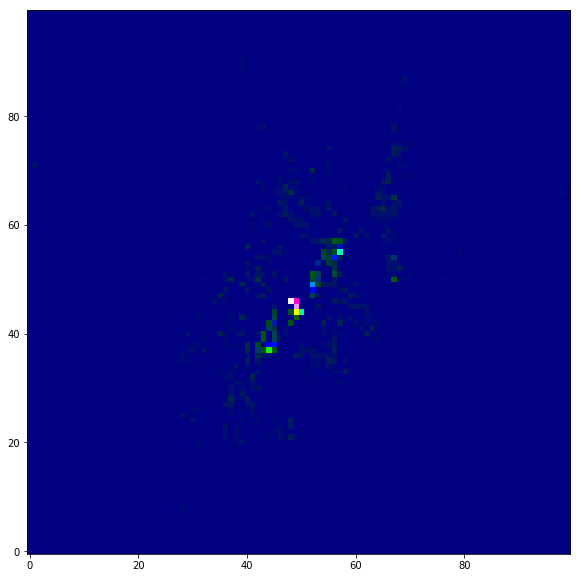

In [31]:
pixel_image(table, 95936);

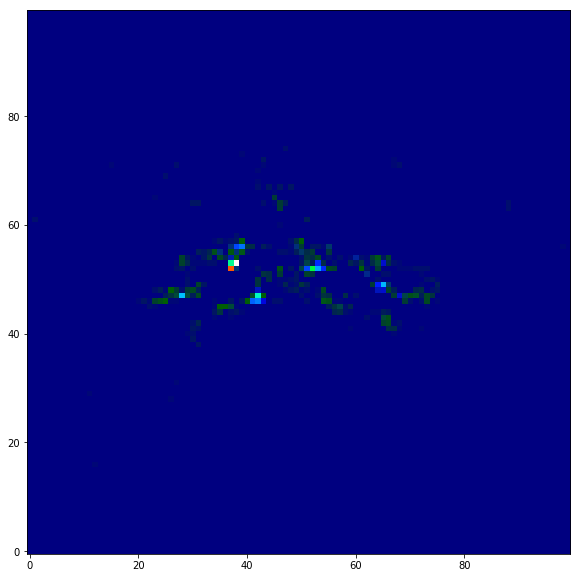

In [32]:
pixel_image(table, 148410);

## Smoothing the pixelated images and signal to noise

In [200]:
def gaussian(sigma, x_0, y_0, x, y, power):
    xs = (x-x_0)**2
    ys = (y-y_0)**2
    gauss_val = power * (e** ((-(xs + ys))/(2*(sigma**2))))
    return gauss_val

In [215]:
table.loc[75219][14::9]

EO STON 1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
EO STON 2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
EO STON 3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
EO STON 4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
EO STON 5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
EO STON 6     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
EO STON 7                                                3.6642
EO STON 8                                               3.81686
EO STON 9                                            [0.0, 0.0]
EO STON 10                                           [0.0, 0.0]
EO STON 11                                              2.49615
EO STON 12                                              2.37625
EO STON 13        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
EO STON 14                                              31.9095
EO STON 15                                              3.51386
EO STON 16                              

In [228]:
def smooth_signal_to_noise(table, index, x_stretch, y_stretch):

    mags = table.loc[index][6::9]
    mags_eo = table.loc[index][12::9]
    ras = np.array(table.loc[index][10::9])
    decs = np.array(table.loc[index][11::9])
    STON_ps = table.loc[index][13::9]
    mag_change = []
    image_ra = []
    image_dec = []
    image_mag = []
    image_ston = []
    observation_number = []
    ps_mag = []
    for n in range(0, len(mags)):
        try:
            if mags[n] !=0:
                image_ra.append(ras[n])
                image_dec.append(decs[n])
                image_mag.append(mags_eo[n])
                observation_number.append(n)
                image_ston.append(STON_ps[n])
                ps_mag.append(mags[n])
        except:
            if np.sum(mags[n]) !=0:
                image_ra.append(ras[n])
                image_dec.append(decs[n])
                image_mag.append(mags_eo[n])
                observation_number.append(n)
                image_ston.append(STON_ps[n])
                ps_mag.append(mags[n])

# xmins = []
    #xmaxs = []
    #ymins = []
    #ymaxs = []
    #magmins = []
    #magmaxs = []
    #for i in range(0, len(image_ra)):
    #    xmins.append(np.min(image_ra[i]))
    #   xmaxs.append(np.max(image_ra[i]))
    #    ymins.append(np.min(image_dec[i]))
    #    ymaxs.append(np.max(image_dec[i]))
    #    magmins.append(np.min(image_mag[i]))
    #    magmaxs.append(np.max(image_mag[i]))
    #xmin = np.min(xmins)
    #xmax = np.max(xmaxs)
    #ymin = np.min(ymins)
    #max = np.max(ymaxs)
    #magmin = np.min(magmins)
    #magmax = np.max(magmaxs)
    
    gleam_ra = table.loc[index]['RA']
    gleam_dec = table.loc[index]['DEC']
    xmin = gleam_ra - x_stretch
    xmax = gleam_ra + x_stretch
    
    ymin = gleam_dec - y_stretch
    ymax = gleam_dec + y_stretch
    
    data = np.matrix(np.zeros((100,100)))
 
    ston_data = np.matrix(np.zeros((100,100)))
    
    x_axis = np.linspace(xmin - 0.001, xmax + 0.001, num=100, endpoint=True)
    y_axis = np.linspace(ymin - 0.001, ymax + 0.001, num=100, endpoint=True)
    
    for m in range(0, len(image_ra)):
        ra = image_ra[m]
        dec = image_dec[m]
        mag = image_mag[m]
        ston = image_ston[m]#should be a single number
        point_mag = ps_mag[m]#also one number 
        
        try:
            for i in range(0, len(ra)):
                x_0 = ra[i]
                y_0 = dec[i]
                power = mag[i][0]
                ston_eo = ston*(power/point_mag)
                
    
                for xind, xval in enumerate(x_axis):
                    for yind, yval in enumerate(y_axis):
                        data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, power)
                        
                for xind, xval in enumerate(x_axis):
                    for yind, yval in enumerate(y_axis):
                        ston_data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, ston_eo)
                        
        except: 
            x_0 = np.array([ra])[0]
            y_0 = np.array([dec])[0]
            power = np.array([mag])[0][0]
    
            for xind, xval in enumerate(x_axis):
                for yind, yval in enumerate(y_axis):
                    data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, power)
                    
  
            for xind, xval in enumerate(x_axis):
                for yind, yval in enumerate(y_axis):
                    ston_data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, ston)
    tot_flux = np.sum(data)
    mean_flux = np.mean(ps_mag)
    flux_offset = tot_flux / mean_flux

    return {'data': data, 'xticks':  x_axis, 'yticks' : y_axis, 
            'observations': observation_number, 'STON_data':ston_data, 'obs_mag': ps_mag}

In [229]:
def plot_smooth_source(table, index):
    d = smooth_signal_to_noise(table, index, .25, .25)

    plt.imshow(d['data'], cmap = 'gist_ncar', origin = 'lower')

    plt.clim(0, np.max(d['data']))
    #plt.colorbar()
    plt.xlabel('RA (Deg)')
    plt.ylabel('DEC (Deg)')

    plt.title('Smoothing of Source {}'.format(index))
    plt.xticks(np.arange(0, 100, 10),np.around(d['xticks'][0::10], decimals = 3))
    plt.yticks(np.arange(0, 100, 10),np.around(d['yticks'][0::10], decimals = 3));

In [230]:
def plot_smooth_ston(table, index):
    
    d = smooth_signal_to_noise(table, index)
        
    ston = d['STON_data']
    plt.imshow(ston, cmap = 'gist_ncar', origin = 'lower')
    plt.clim(0, np.max(ston))
    plt.colorbar()
    plt.xlabel('RA (Deg)')
    plt.ylabel('DEC (Deg)')

    plt.title('Signal to Noise Ratio for Source 75219')
    plt.xticks(np.arange(0, 100, 10),np.around(d['xticks'][0::10], decimals = 3))
    plt.yticks(np.arange(0, 100, 10),np.around(d['yticks'][0::10], decimals = 3));

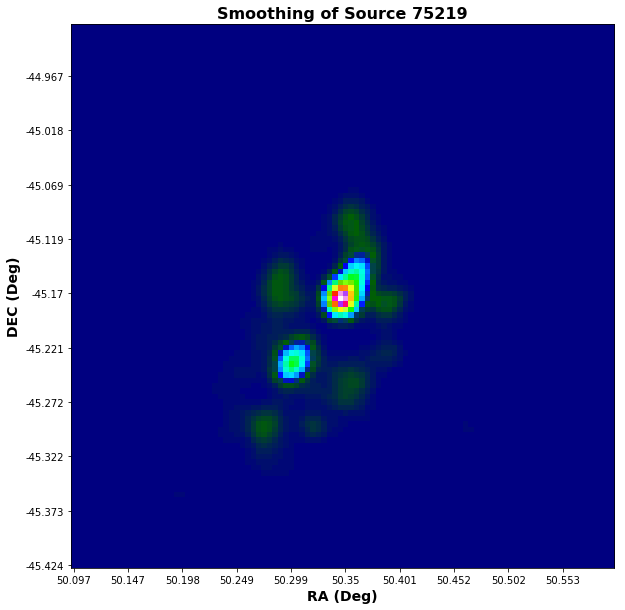

In [231]:
plot_smooth_source(table, 75219)
plt.savefig('/Users/student/kelcey/Images/Source75219smooth')

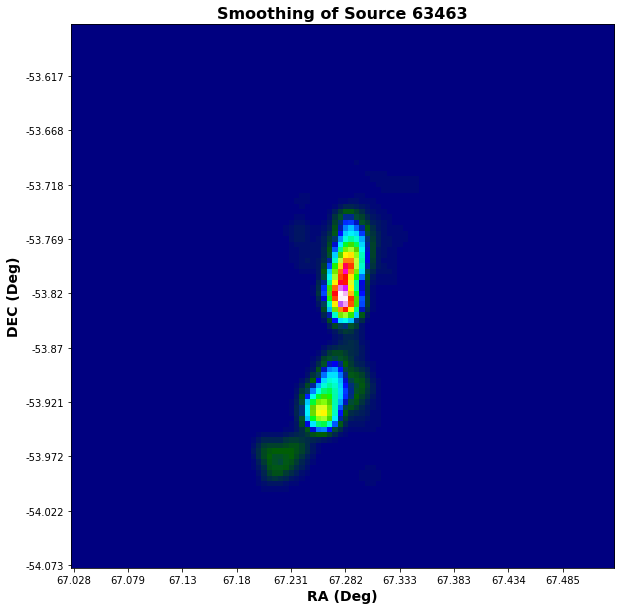

In [232]:
plot_smooth_source(table, 63463)
plt.savefig('/Users/student/kelcey/Images/Source63463smooth')

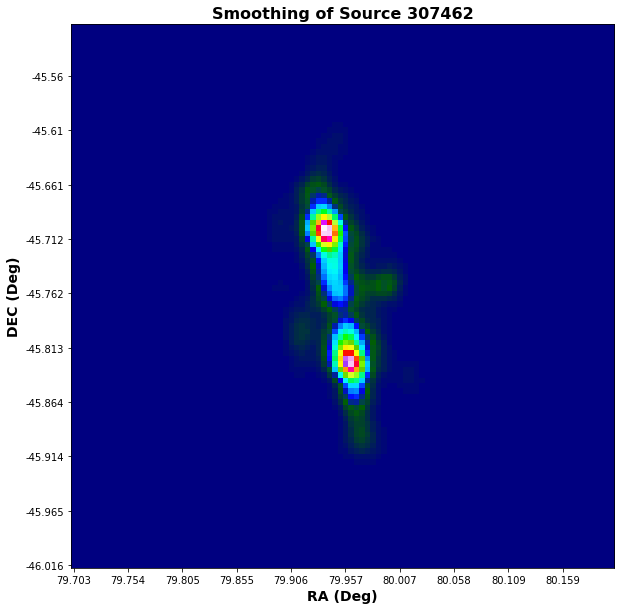

In [233]:
plot_smooth_source(table, 307462)
plt.savefig('/Users/student/kelcey/Images/Source307462smooth')

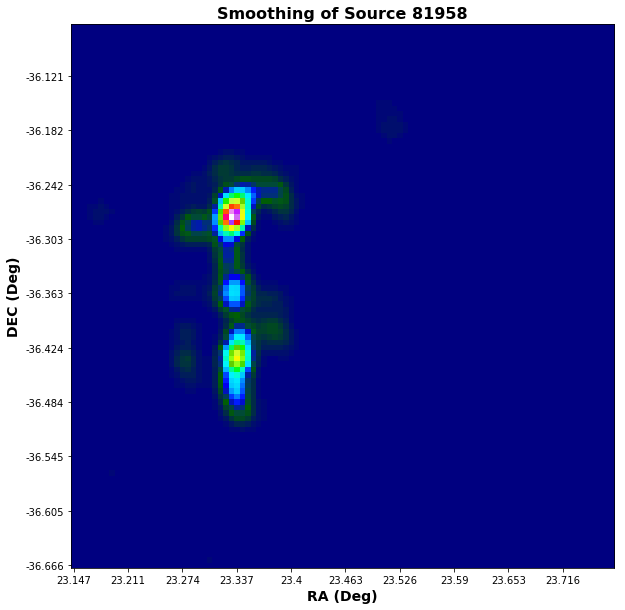

In [41]:
plot_smooth_source(table, 81958)

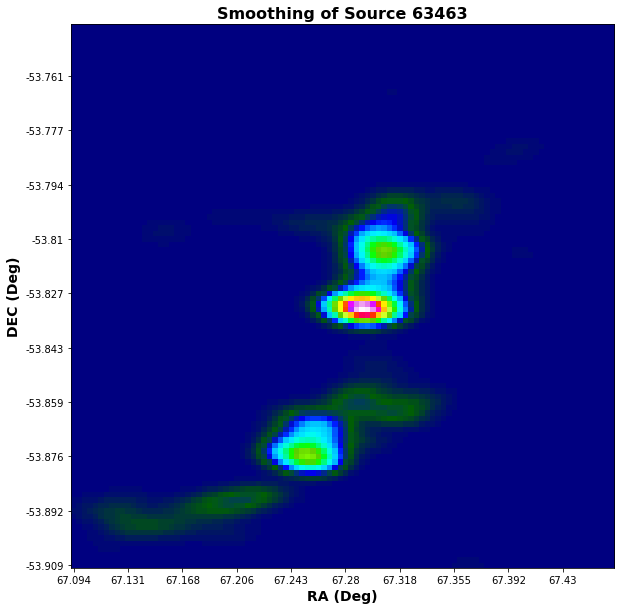

In [42]:
plot_smooth_source(table, 63463)

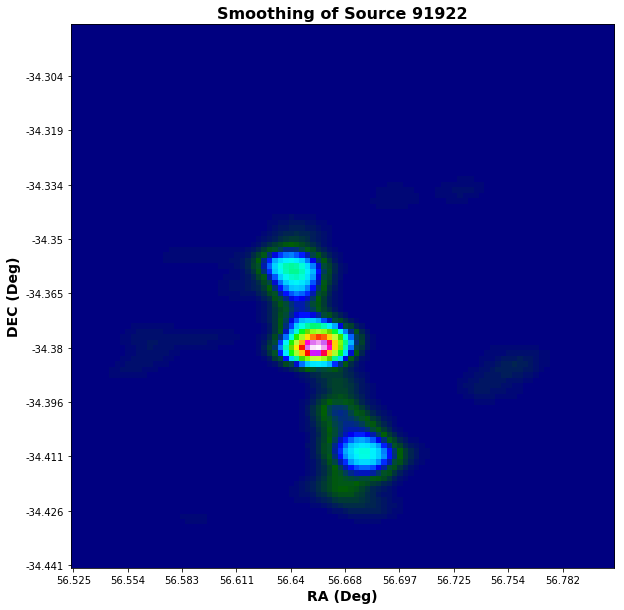

In [43]:
plot_smooth_source(table, 91922)

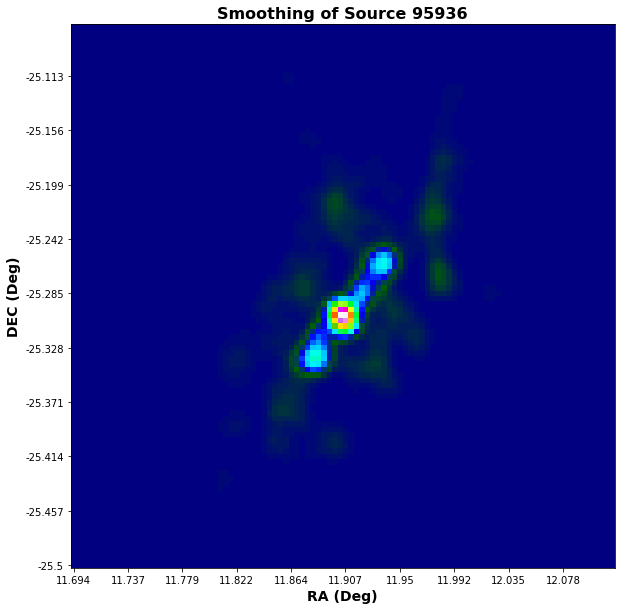

In [44]:
plot_smooth_source(table, 95936)

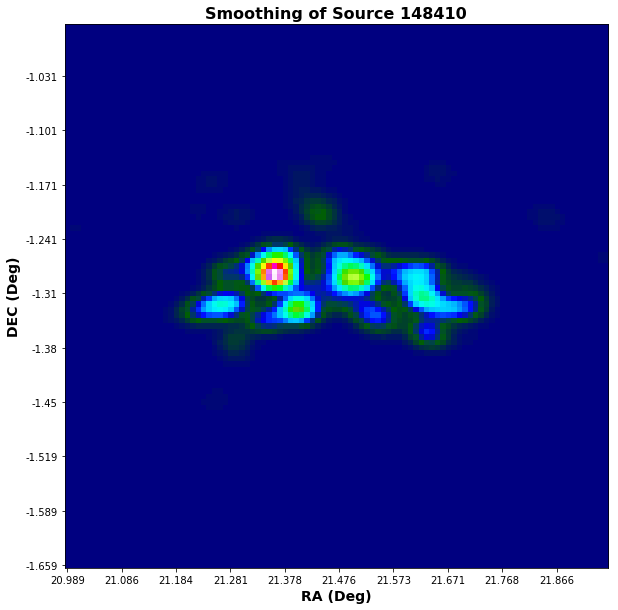

In [45]:
plot_smooth_source(table, 148410)

In [71]:
def get_cut_data(table, index, cut):
    d = smooth_signal_to_noise(table, index)

    data = d['data']


    xs = np.arange(0, 100)
    ys = np.arange(0,100)
    new_data = np.matrix(np.zeros((100,100)))
    coords = product(xs, ys)
    for coord in set(coords):
        if d['STON_data'][coord] < cut:
            new_data[coord] = 0
        else:
            new_data[coord] = data[coord]
        
    x = np.arange(0, 100)
    y = np.arange(0,100)
    prods = product(x, ys)
    coords = []
    for i in prods:
        coords.append(i)
    coords[0]


    
    
    tot_flux = np.sum(new_data)
    mean_flux = np.mean(d['obs_mag'])
    flux_offset = tot_flux / mean_flux
    corrected_data = new_data/flux_offset
    
    
    xcoords = []
    ycoords = []
    powers = []
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg(0)
    for coord in coords:
        if corrected_data[coord] !=0:
            xcoords.append(coord[0])
            ycoords.append(coord[1])
            powers.append(corrected_data[coord])
    
    
    plt.scatter(xcoords, ycoords, s = powers, marker = '*', color = 'b', transform = rot + base)
    plt.xticks(np.arange(0, 100, 10),np.around(d['xticks'][0::10], decimals = 3))
    plt.yticks(np.arange(0, 100, 10),np.around(d['yticks'][0::10], decimals = 3))
    plt.ylabel('DEC (Deg)')
    plt.title('Cut Off at {} STON'.format(cut, np.sum(powers)))
    plt.xlabel('RA (Deg)');
    return {'xcoords': xcoords, 'ycoords': ycoords, 'powers': powers, 'data': corrected_data}


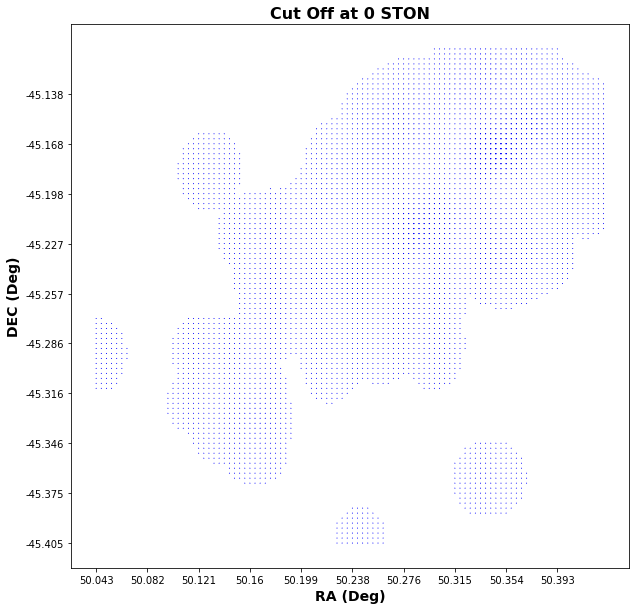

In [72]:
x = get_cut_data(table, 75219, 0)

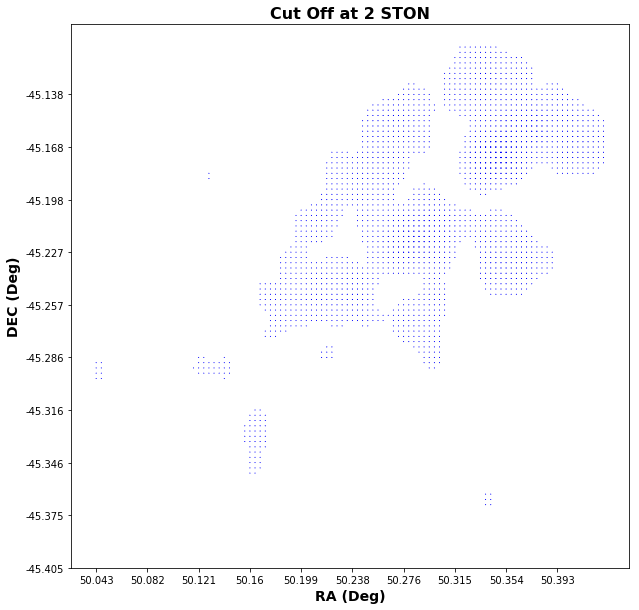

In [73]:
y = get_cut_data(table, 75219, 2)

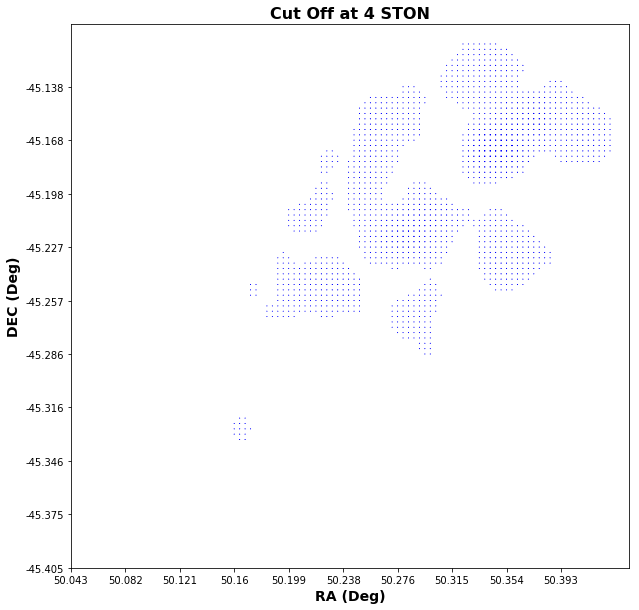

In [74]:
z = get_cut_data(table, 75219, 4)

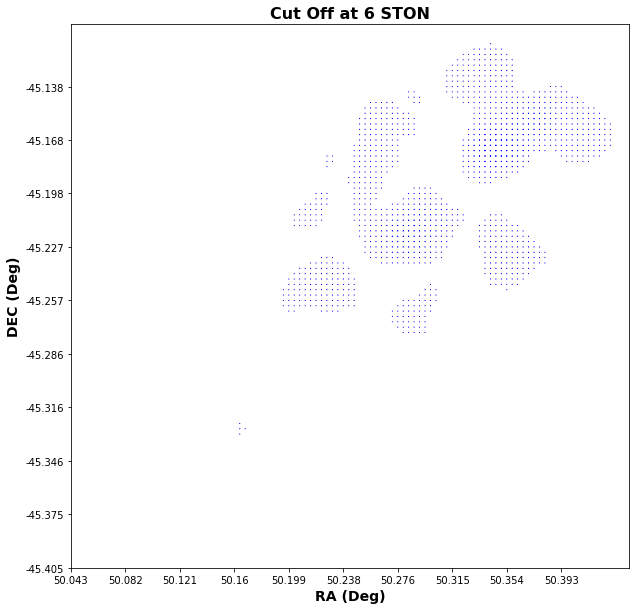

In [75]:
m = get_cut_data(table, 75219, 6)

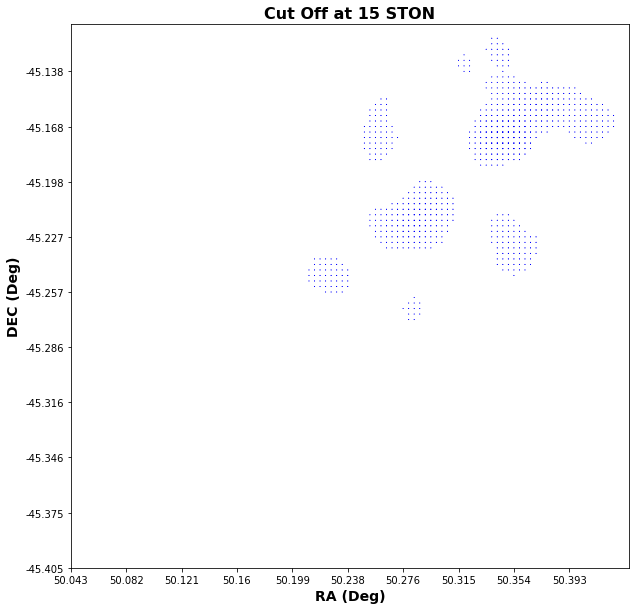

In [76]:
k = get_cut_data(table, 75219, 15)

## Looking at Individual Observations

In [146]:
def indv_obs_smooth(table, index, x_stretch, y_stretch):
    """
    table is a Pandas DataFrame generated by the match_to_GELAM function
    
    index is the index of the object to be imaged
    
    """
    
    obs_data = []
    
    mags = table.loc[index][6::9]
    mags_eo = table.loc[index][12::9]
    ras = np.array(table.loc[index][10::9])
    decs = np.array(table.loc[index][11::9])
    mag_change = []
    image_ra = []
    image_dec = []
    image_mag = []
    for n in range(0, len(mags)):
        if mags[n] !=0:
            image_ra.append(ras[n])
            image_dec.append(decs[n])
            image_mag.append(mags_eo[n])
                
   # xmins = []
   # xmaxs = []
   # ymins = []
    #ymaxs = []
    #magmins = []
    #magmaxs = []
    #for i in range(0, len(image_ra)):
     #   xmins.append(np.min(image_ra[i]))
      #  xmaxs.append(np.max(image_ra[i]))
       # ymins.append(np.min(image_dec[i]))
        #ymaxs.append(np.max(image_dec[i]))
        #magmins.append(np.min(image_mag[i]))
        #magmaxs.append(np.max(image_mag[i]))
    #xmin = np.min(xmins)
    #xmax = np.max(xmaxs)
    #ymin = np.min(ymins)
    #ymax = np.max(ymaxs)
    #magmin = np.min(magmins)
    #magmax = np.max(magmaxs)
    
    xmin = table.loc[index]['RA'] - x_stretch
    xmax = table.loc[index]['RA'] + x_stretch
    
    ymin = table.loc[index]['DEC'] - y_stretch
    ymax = table.loc[index]['DEC'] + y_stretch
    
    x_axis = np.linspace(xmin - 0.001, xmax + 0.001, num=100, endpoint=True)
    y_axis = np.linspace(ymin - 0.001, ymax + 0.001, num=100, endpoint=True)
    
   
    for m in range(0, len(image_ra)):
        ra = image_ra[m]
        dec = image_dec[m]
        mag = image_mag[m]
        plt.figure()
        data = np.matrix(np.zeros((100,100)))
        try:
            for i in range(0, len(ra)):
                x_0 = ra[i]
                y_0 = dec[i]
                power = mag[i][0]
    
                for xind, xval in enumerate(x_axis):
                    for yind, yval in enumerate(y_axis):
                        data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, power)
        except:
            x_0 = ra
            y_0 = dec
            power = mag[0]
    
            for xind, xval in enumerate(x_axis):
                for yind, yval in enumerate(y_axis):
                    data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, power)

    return{'data': data, 'x_axis_ticks': x_axis, 'y_axis_ticks': y_axis}              

In [182]:
def indv_obs_smooth(table, index, x_stretch, y_stretch):
    """
    table is a Pandas DataFrame generated by the match_to_GELAM function
    
    index is the index of the object to be imaged
    
    """
    
    obs_data = []
    
    mags = table.loc[index][6::9]
    mags_eo = table.loc[index][12::9]
    ras = np.array(table.loc[index][10::9])
    decs = np.array(table.loc[index][11::9])
    
    gleam_ra = table.loc[index]['RA']
    gleam_dec = table.loc[index]['DEC']
    
    mag_change = []
    image_ra = []
    image_dec = []
    image_mag = []
    for n in range(0, len(mags)):
        try:
            if mags[n] !=0:
                image_ra.append(ras[n])
                image_dec.append(decs[n])
                image_mag.append(mags_eo[n])
        except:
            if np.sum(mags[n]) !=0:
                image_ra.append(ras[n])
                image_dec.append(decs[n])
                image_mag.append(mags_eo[n])
                
  
    #Un-comment to create code that makes its own x and y limits
   # xmins = []
    #xmaxs = []
    #ymins = []
    #ymaxs = []
    #magmins = []
    #magmaxs = []
    #for i in range(0, len(image_ra)):
     #   xmins.append(np.min(image_ra[i]))
      #  xmaxs.append(np.max(image_ra[i]))
        #ymins.append(np.min(image_dec[i]))
        #ymaxs.append(np.max(image_dec[i]))
        #magmins.append(np.min(image_mag[i]))
        #magmaxs.append(np.max(image_mag[i]))
    #xmin = np.min(xmins)
    #xmax = np.max(xmaxs)
    #ymin = np.min(ymins)
    #ymax = np.max(ymaxs)
    #magmin = np.min(magmins)
    #magmax = np.max(magmaxs)
    
    xmin = gleam_ra - x_stretch
    xmax = gleam_ra + x_stretch
    
    ymin = gleam_dec - y_stretch
    ymax = gleam_dec + y_stretch
    
    
    x_axis = np.linspace(xmin - 0.001, xmax + 0.001, num=100, endpoint=True)
    y_axis = np.linspace(ymin - 0.001, ymax + 0.001, num=100, endpoint=True)
    
   
    for m in range(0, len(image_ra)):
        ra = image_ra[m]
        dec = image_dec[m]
        mag = image_mag[m]
        plt.figure()
        data = np.matrix(np.zeros((100,100)))
        try:
            for i in range(0, len(ra)):
                x_0 = ra[i]
                y_0 = dec[i]
                power = mag[i][0]
    
                for xind, xval in enumerate(x_axis):
                    for yind, yval in enumerate(y_axis):
                        data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, power)
        except:
            x_0 = ra
            y_0 = dec
            power = mag[0]
    
            for xind, xval in enumerate(x_axis):
                for yind, yval in enumerate(y_axis):
                    data[xind, yind] += gaussian(1.5*(x_axis[1]-x_axis[0]), x_0, y_0, xval, yval, power)
        obs_data.append(data)                


    return{'data': obs_data, 'x_axis_ticks': x_axis, 'y_axis_ticks': y_axis}              

In [183]:
def make_png(table, index):
    obs = indv_obs_smooth(table, index, .25, .25)
    rng = np.array(obs['data']).shape[0]
    for i in range(0, rng):
        plt.imshow(obs['data'][i][::-1], cmap = 'gist_ncar')
        plt.xticks(np.arange(0, 100, 10),np.around(obs['x_axis_ticks'][0::10], decimals = 3))
        plt.yticks(np.arange(0, 100, 10),np.around(obs['y_axis_ticks'][0::10], decimals = 3))
        plt.title('Source {}, Observation {} in Range 0-15'.format(index, i))
        plt.xlabel('RA (Deg)')
        plt.savefig('/Users/student/kelcey/Images/Source_{}_Obs_{}_in_range_0-81'.format(index, i))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

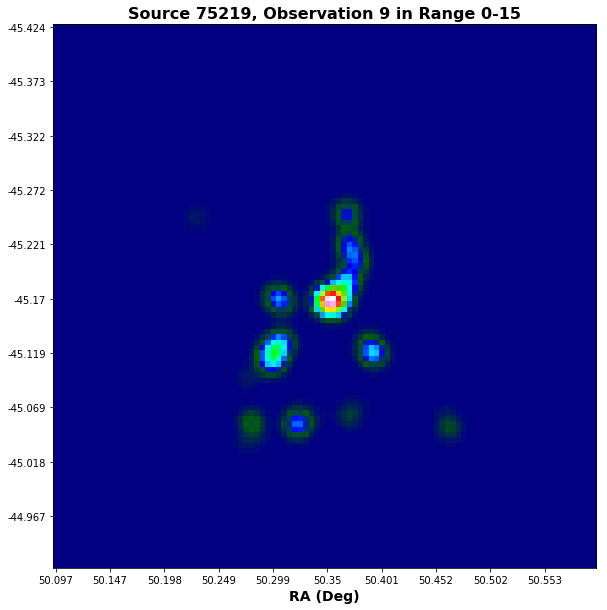

In [184]:
make_png(table, 75219)

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

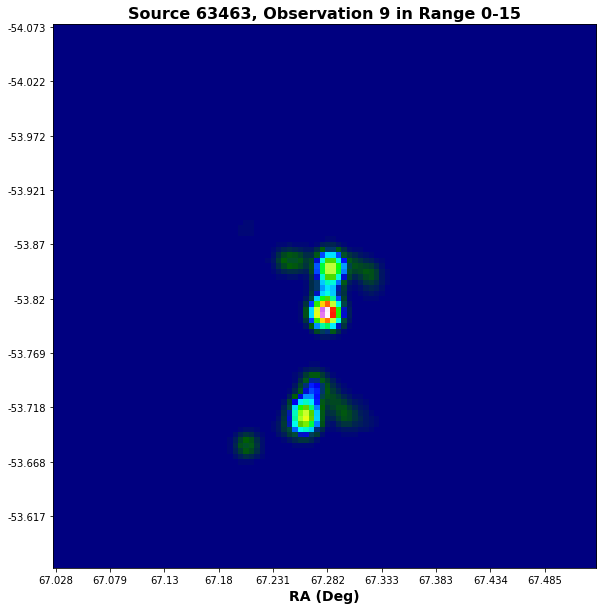

In [185]:
make_png(table, 63463)

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

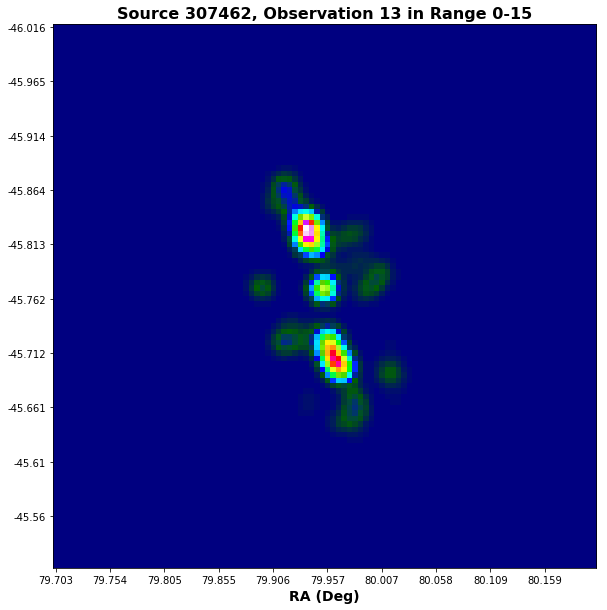

In [195]:
make_png(table, 307462)

In [51]:
def make_fits_file(table, index):
    obs = indv_obs_smooth(table, index)
    rng = np.array(obs['data']).shape[0]
    for i in range(0, rng):
        hdu = fits.PrimaryHDU(obs['data'][i][::-1])
        hdu.writeto('source {} file {}'.format(index, i))

In [52]:
make_fits_file(table, 75219)

In [53]:
make_fits_file(table, 63463)